In [27]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [3]:

# Get the list of S&P 500 constituents
tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)


[*********************100%%**********************]  504 of 504 completed


3 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')
['BRK.B', '-']: Exception('%ticker%: No data found, symbol may be delisted')


In [28]:
# Function to get lagged start and end periods
def get_lagged_periods(time_period):
    start_period = -20 - time_period
    end_period = -20  # latest data entry
    return start_period, end_period

In [34]:

# Function to calculate momentum factors
def calculate_momentum_factors(tickers, time_period):
    start_period, end_period = get_lagged_periods(time_period)

    # Calculating 52 Week trend
    """First parameter of polyfit takes the length of the slice of data we are using
    Second parameter takes the closed prices of the same slice of data. X and Y relationship.
    """
    lagged_closed_price = sp500[start_period:end_period]
    polyfit_regression = np.polyfit(range(len(lagged_closed_price)), lagged_closed_price, 1) 
    slope_info = pd.DataFrame(polyfit_regression) # Convert so that we can use the results
    slope_info.columns = sp500.columns # Setting column names to match ticker
    _52_week_trend= slope_info.iloc[0] # Only need first row 


    # pct above 260 day low
    current_price_minus_min = sp500.iloc[-20] - lagged_closed_price.min() #the difference of price
    percent_above_260 = (current_price_minus_min / lagged_closed_price.min()) * 100 # then divide over the low

    # Oscillator calculations
    
    """ Close - 4wk low , divided by 4week high - 4week low) - Close - 52wk low , divided by 52week high - 52week low)
     
     The equation is same, use for loop and change index from 4week to 52 week
     end_period -20 is just the latest data entry in slice of data back 20 entries(4 weeks)
     start_period -20 is same logic as we want to maintain the 252 constant period."""
    data_indexes = [end_period-20, start_period-20]
    oscillator_ratios = []
    for index in data_indexes:
        close_minus_low = sp500.iloc[end_period] - sp500[index:].min()
        ratio = close_minus_low / (sp500[index:].max() - sp500[index:].min())
        oscillator_ratios.append(ratio)
    oscillator = (oscillator_ratios[0] - oscillator_ratios[1]) * 100

    # 39 week returns
    price_39_weeks_ago = sp500.iloc[start_period+195] #195 data entries previous (39 * 5)
    price_difference_39_weeks = sp500.iloc[start_period] - price_39_weeks_ago
    _39_week_returns = price_difference_39_weeks / price_39_weeks_ago # rate of change formula

    # Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)
    weekly_means = sp500[start_period:end_period].rolling(5).mean()
    weekly_volume = volume[start_period:end_period].rolling(5).mean()
    vpt = weekly_means.pct_change() * weekly_volume
    volume_price_trend = vpt.sum()

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39 Week Return'] = _39_week_returns
    new_table['51 Week Volume Price Trend'] = volume_price_trend

    return new_table



In [35]:
# Example usage
time_period = 1260  # 1 year 252, 5 year 1260 
start_period = -20 - time_period
end_period = -20  

momentum_factors = calculate_momentum_factors(tickers, time_period)
momentum_factors



,Slope 52 Week Trend-Line,Percent above 260,4/52 Week Oscillator,39 Week Return,51 Week Volume Price Trend
A,0.063805,79.696665,-15.757231,-0.046634,-1.722412e+03
AAL,-0.014251,30.530976,20.376608,0.418294,7.391174e+07
AAPL,0.121493,446.325169,-26.171919,-0.017200,8.685558e+07
ABBV,0.086764,166.908343,-69.170694,0.257474,1.138116e+06
ABNB,NaN,43.229488,-11.273696,NaN,-1.506849e+06
...,...,...,...,...,...
YUM,0.038298,137.610426,-7.152793,-0.245735,2.260303e+05
ZBH,0.002870,38.553798,-15.698202,-0.148876,-9.233132e+05
ZBRA,0.110112,44.282716,5.528421,-0.105242,-3.794557e+05
ZION,0.005692,72.098768,11.160130,0.195448,-6.577286e+06


In [36]:
z_scores = (momentum_factors - momentum_factors.mean()) / momentum_factors.std()
z_scores = z_scores.sum(axis=1)



In [37]:
z_scores.sort_values(ascending=True, inplace= True)
long_basket= z_scores[-10:]
short_basket = z_scores[:10]

print("Long Basket:", long_basket)
print("Short Basket:", short_basket)


Long Basket: DVN      5.322833
APA      5.672750
CMG      6.284589
AMD      6.810531
TRGP     7.042724
AZO      9.341126
NVDA    11.214678
PCG     11.715520
NVR     12.397340
TSLA    30.920706
dtype: float64
Short Basket: KMI   -3.224873
STE   -2.827429
WEC   -2.807041
FE    -2.763650
BSX   -2.648297
CHD   -2.641476
MRK   -2.522505
SO    -2.481829
NOC   -2.420463
EG    -2.411032
dtype: float64


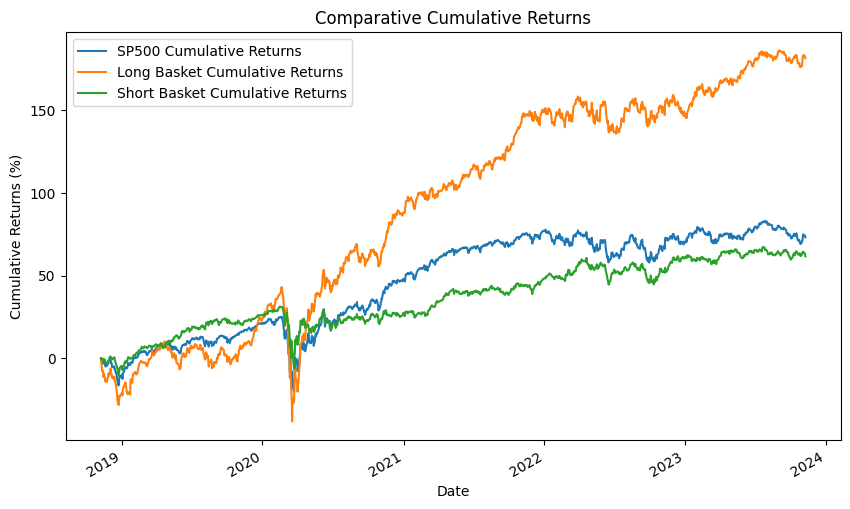

In [38]:
#Back-Test period of time_period year (20 Day Lag)

long_list =long_basket.index
short_list= short_basket.index

long_basket_close =sp500[start_period:end_period][long_list]
short_basket_close =sp500[start_period:end_period][short_list]


# I should make this next part a function, for autonomy
returns = sp500[start_period:end_period].pct_change()*100
returns = returns.mean(axis=1)
cumulative_returns = returns.cumsum()

long_returns = long_basket_close.pct_change()*100
long_returns = long_returns.mean(axis=1)
long_cumulative_returns = long_returns.cumsum()

short_returns = short_basket_close.pct_change()*100
short_returns = short_returns.mean(axis=1)
short_cumulative_returns = short_returns.cumsum()



plt.figure(figsize=(10,6))
cumulative_returns.plot(label='SP500 Cumulative Returns')
long_cumulative_returns.plot(label='Long Basket Cumulative Returns')
short_cumulative_returns.plot(label='Short Basket Cumulative Returns')

plt.legend()
plt.title('Comparative Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.show()




# There is an issue with the way I'm graphing cumulative returns. The spread gets bigger as time increases.


## also 39 week return needs be adjusted
